## Load all prescales info first

In [1]:
# read good_run_list.list
def get_good_run_list():
    good_run_list = []
    with open("../../lists/good_run_list.list") as f:
        for line in f:
            good_run_list.append(int(line.strip()))
    return good_run_list
good_run_list = get_good_run_list()
# this will be used as bins for the histograms

In [2]:
import ROOT
%jsroot on

import math
# calculate events ratio from vertex histograms
path='/home/prozorov/dev/star/jets_pp_2012/output/'
vertex_hists = {}
gaus_fits = {}
ratios = {}
triggers = ['JP2', 'HT2', 'MB']
canvas = ROOT.TCanvas('canvas', '', 1200, 400)
canvas.Divide(3, 1)
canvas.Draw()

line = ROOT.TLine()
line.SetLineColor(ROOT.kRed)
line.SetLineStyle(2)

text =ROOT.TLatex()
text.SetTextSize(0.03)
text.SetTextColor(ROOT.kRed)

for i, trigger in enumerate(triggers):
    file = ROOT.TFile(path + f'jets_{trigger}.root')
    vertex_hist = file.Get('hVertexZ')
    vertex_hist.SetName(f'hVertexZ_{trigger}')
    vertex_hist.SetDirectory(0)
    vertex_hist.SetTitle(trigger)
    vertex_hist.GetXaxis().SetRangeUser(-35, 35)
    vertex_hists[trigger] = vertex_hist

    canvas.cd(i + 1)
    vertex_hist.Draw('hist')
    gaus_fit = ROOT.TF1(f"gaus_{trigger}", "gaus", -35, 35)
    vertex_hist.Fit(gaus_fit, "REMQ")
    gaus_fits[trigger] = gaus_fit

    binwidth = vertex_hist.GetBinWidth(2)
    integral = vertex_hist.Integral(vertex_hist.FindBin(-30), vertex_hist.FindBin(30)) * binwidth
    total_integral = math.sqrt(2 * math.pi) * gaus_fit.GetParameter(0) * gaus_fit.GetParameter(2)
    ratio = integral / total_integral
    ratios[trigger] = ratio

    line.DrawLine(-30, 0, -30, 1.05 * vertex_hist.GetMaximum())
    line.DrawLine(30, 0, 30, 1.05 * vertex_hist.GetMaximum())
    text.DrawLatexNDC(0.2, 0.3, f'{ratio:.2f} total')
# print ratio
ratio_events_jp2= ratios['JP2']/ratios['MB']
ratio_events_ht2= ratios['HT2']/ratios['MB']

ratio_passed_events={
    'JP2': ratio_events_jp2,
    'HT2': ratio_events_ht2
}

print(f'JP2 events ratio: {ratio_events_jp2:.10f}')
print(f'HT2 events ratio: {ratio_events_ht2:.10f}')

Welcome to JupyROOT 6.30/04


Warning in <TClass::Init>: no dictionary for class TStarJetVectorJet is available
Warning in <TClass::Init>: no dictionary for class TStarJetVector is available


JP2 events ratio: 0.6269002141
HT2 events ratio: 0.6218409705


In [2]:
import pandas as pd
lumi_MB_JP2 =  pd.read_csv("lumi_VPDMB_JP2.csv", index_col="run")
lumi_MB_HT2 =  pd.read_csv("lumi_VPDMB_BHT2.csv",index_col="run")
# keep only JP2 columns 'sampled_lumi_JP2', 'prescale_JP2', 'livetime_JP2', 'nevents_JP2', 
lumi_JP2=lumi_MB_JP2[['sampled_lumi_JP2', 'prescale_JP2', 'livetime_JP2', 'nevents_JP2']]
# add lumi_JP2 to lumi_MB_HT2
lumi=lumi_MB_HT2.join(lumi_JP2)
# show na values
# bad runs for BHT2  - 13052057 ,  13052059
# unique run for BHT2 only - 13054047 (JP2 was absent)
# drop HT2_weight
lumi.drop(columns=['HT2_weight'], inplace=True)
    #  'sampled_lumi_MB', 'prescale_MB', 'livetime_MB', 'nevents_MB',
    #  'sampled_lumi_HT2', 'prescale_HT2', 'livetime_HT2', 'nevents_HT2',
    #  'sampled_lumi_JP2', 'prescale_JP2', 'livetime_JP2', 'nevents_JP2'
# calculate ratios for JP2 and HT2 to MB

# add good run list with na values

lumi = lumi.reindex(good_run_list)

triggers = ['JP2', 'HT2']
for trigger in triggers:
    lumi[f'prescale_MB_over_{trigger}'] = lumi[f'prescale_MB'] / lumi[f'prescale_{trigger}']
    lumi[f'livetime_{trigger}_over_MB'] = lumi[f'livetime_{trigger}'] / lumi[f'livetime_MB']
    lumi[f'nevents_MB_over_{trigger}'] = lumi[f'nevents_MB'] / lumi[f'nevents_{trigger}']

In [3]:
lumi

,sampled_lumi_MB,prescale_MB,livetime_MB,nevents_MB,sampled_lumi_HT2,prescale_HT2,livetime_HT2,nevents_HT2,sampled_lumi_JP2,prescale_JP2,livetime_JP2,nevents_JP2,prescale_MB_over_JP2,livetime_JP2_over_MB,nevents_MB_over_JP2,prescale_MB_over_HT2,livetime_HT2_over_MB,nevents_MB_over_HT2
run,,,,,,,,,,,,,,,,,,
13043027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13043029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13043034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13043046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13043062,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13072016,0.000069,98.488945,0.915187,1727708.0,0.056269,1.0,0.915825,95108.0,0.056108,1.0,0.913190,127776.0,98.488945,0.997817,13.521381,98.488945,1.000697,18.165748
13072017,0.000050,94.062065,0.913841,1239436.0,0.038824,1.0,0.915729,65186.0,0.038670,1.0,0.912101,87599.0,94.062065,0.998096,14.148974,94.062065,1.002066,19.013837
13072018,0.000050,89.829498,0.913085,1249065.0,0.037561,1.0,0.913867,63087.0,0.037365,1.0,0.909080,83824.0,89.829498,0.995614,14.901043,89.829498,1.000857,19.799087


## Analyze the data MB, JP2, HT2

In [5]:
from IPython.display import display, Math

equation = (r"""
        N_{\text{corresponding events}}^{\text{MB}} = \sum_{\text{runs}} N_{\text{events}}^{\text{JP2}} 
        \times \textcolor{red}{\frac{\text{PS}^{\text{MB}}}{\text{PS}^{\text{JP2}}} }
        \times \textcolor{green}{\frac{\text{LT}^{\text{JP2}}}{\text{LT}^{\text{MB}}} }
        \times \textcolor{orange}{\frac{N_{\text{events,max}}^{\text{MB}}}{N_{\text{events,max}}^{\text{JP2}}}} 
        \times \textcolor{olive}{\frac{R_{\text{MB}}}{R_{\text{JP2}}}}
        \times \text{triggerMatch}
""")
description = r"""
- $ N_{\text{events}}^{\text{JP2}}$ - number of currently analyzed JP2 events  
- $ \textcolor{red}{\text{PS}^{\text{JP2}}(run)}$ - prescale JP2 $=1$  
- $ \textcolor{red}{\text{PS}^{\text{MB}}(run)}$ - prescale minbias $\approx 100$  
- $ \textcolor{green}{\text{LT}^{\text{JP2}}(run)}$ - livetime JP2 $\approx 0.98$  
- $ \textcolor{green}{\text{LT}^{\text{MB}}(run)}$ - livetime minbias $\approx 0.98$  
- $ \textcolor{orange}{N_{\text{events,max}}^{\text{MB}}(run)}$ - maximum number of events MB  
- $ \textcolor{orange}{N_{\text{events,max}}^{\text{JP2}}(run)}$ - maximum number of events JP2  
- $ \textcolor{olive}{R_{\text{MB}}}$ - ratio of passed events MB after vertex cut $\approx 0.8$ 
- $ \textcolor{olive}{R_{\text{JP2}}}$ - ratio of passed events JP2 $\approx 0.6$ 
"""

display(Math(equation))


display(Math(description))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

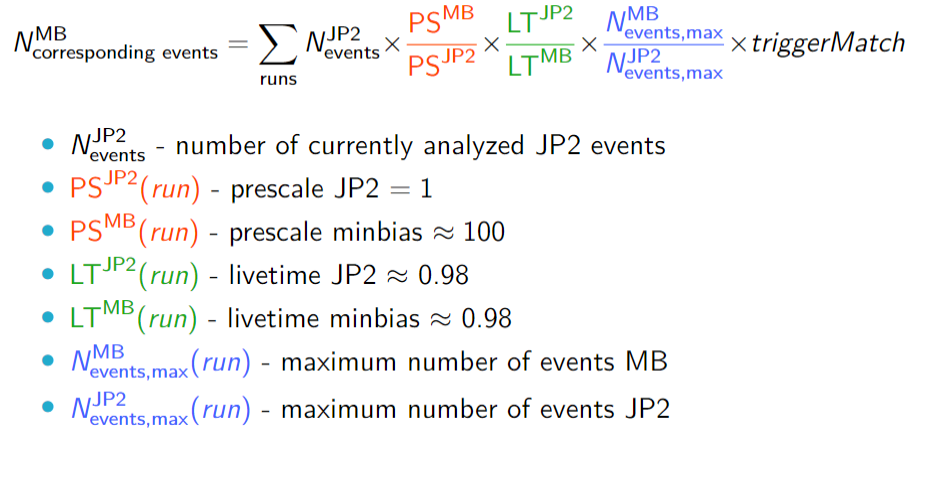

In [6]:

def dataframe_to_TH1(df,column, hist_name="hist"):
    """
    Convert a Pandas DataFrame with into a ROOT TH1D histogram.
    Returns:
    - ROOT.TH1D histogram with custom bin labels.
    """
    rows = df.index.to_list()  # Extract run IDs
    entries = df[column].to_list()  # Extract event counts
    name = df.index.name  # Get the name of the index column
    n_bins = len(rows)
    hist = ROOT.TH1D(hist_name, hist_name, n_bins, 0, n_bins)  # Create histogram
    # Assign bin labels and fill histogram
    for i, run_id in enumerate(rows):
   
        bin_index = i + 1  # ROOT bins start from 1
        hist.GetXaxis().SetBinLabel(bin_index, str(run_id))  # Set custom labels
        # skip nan values
        if entries[i] == entries[i]:        
            hist.SetBinContent(bin_index, entries[i])  # Fill with event counts
    return hist

save_file= ROOT.TFile("lumi.root", "RECREATE")

# sampled_lumi_MB	prescale_MB	livetime_MB	nevents_MB

for trigger in [ 'JP2', 'HT2','MB']:
    can = ROOT.TCanvas(f'can_{trigger}', f'can_{trigger}', 800, 600)
    can.Draw()
    can.SetLogy()
    
    luminosity = dataframe_to_TH1(lumi, f'sampled_lumi_{trigger}', f'luminosity_{trigger}')
    prescale=dataframe_to_TH1(lumi, f'prescale_{trigger}', f'prescale_{trigger}')
    livetime=dataframe_to_TH1(lumi, f'livetime_{trigger}', f'livetime_{trigger}')
    maxnevent=dataframe_to_TH1(lumi, f'nevents_{trigger}', f'nevents_{trigger}')

    if trigger in ['JP2', 'HT2']:
        prescale_ratio = dataframe_to_TH1(lumi, f'prescale_MB_over_{trigger}', f'prescale_MB_over_{trigger}')
        livetime_ratio = dataframe_to_TH1(lumi, f'livetime_{trigger}_over_MB', f'livetime_{trigger}_over_MB')
        maxnevent_ratio = dataframe_to_TH1(lumi, f'nevents_MB_over_{trigger}', f'nevents_MB_over_{trigger}')
        luminosity.SetMarkerColor(ROOT.kRed)
        luminosity.SetLineColor(ROOT.kRed)
        luminosity.SetMarkerStyle (23)
        luminosity.SetMarkerSize(0.8)
        prescale_ratio.SetMarkerColor(ROOT.kMagenta+1) 
        prescale_ratio.SetLineColor(ROOT.kMagenta+1)
        prescale_ratio.SetMarkerStyle (20)
        prescale_ratio.SetMarkerSize(0.8)
        livetime_ratio.SetMarkerColor(ROOT.kAzure)
        livetime_ratio.SetLineColor(ROOT.kAzure)
        livetime_ratio.SetMarkerStyle (21)
        livetime_ratio.SetMarkerSize(0.8)
        maxnevent_ratio.SetMarkerColor(ROOT.kOrange+1)
        maxnevent_ratio.SetLineColor(ROOT.kOrange+1)
        maxnevent_ratio.SetMarkerStyle (22)
        maxnevent_ratio.SetMarkerSize(0.8)
        leg = ROOT.TLegend(0.6, 0.7, 0.9, 0.9)        
        leg.AddEntry(prescale_ratio, f'prescale MB/{trigger}', 'p')
        leg.AddEntry(livetime_ratio, f'livetime {trigger}/MB', 'p')
        leg.AddEntry(maxnevent_ratio, f'maxnevents MB/{trigger}', 'p')
        prescale_ratio.SetTitle(f'{trigger};runid; ratio')
        # set grid
        prescale_ratio.GetYaxis().SetRangeUser(0.2, prescale_ratio.GetMaximum()*1.2)
        prescale_ratio.Draw("pl")
        livetime_ratio.Draw("lp same")
        maxnevent_ratio.Draw("lp same ")
        leg.Draw()

    save_file.cd()
    can.Write()
    prescale.Write()
    livetime.Write()
    maxnevent.Write()
    prescale_ratio.Write()
    livetime_ratio.Write()
    maxnevent_ratio.Write()
    luminosity.Write()

In [7]:
save_file.Close()

In [4]:
run_map = {run: i for i, run in enumerate(lumi.index.tolist())}

In [6]:
# dump run_map to file
with open('run_map.txt', 'w') as f:
    for run, i in run_map.items():
        f.write(f'{run} {i}\n')

In [ ]:
# read run_map from file
run_map = {}
with open('run_map.txt', 'r') as f:
    for line in f:
        run, i = line.strip().split()
        run_map[int(run)] = int(i)

In [ ]:
import ROOT
import uproot
import awkward as ak
import numpy as np
path='/home/prozorov/dev/star/jets_pp_2012/output/'
triggers = ['MB', 'JP2', 'HT2']
tree_name = 'ResultTree'  # Update this to your tree name
branch_names = ['runid1', 'pt', 'trigger_match_jp', 'trigger_match_ht']
pt_vs_run_raw = {}
pt_vs_run_trigger = {}

run_map = {run: i for i, run in enumerate(lumi.index.tolist())}

run_map_inv = {i: run for i, run in enumerate(lumi.index.tolist())}

pt_reco_bins = (6.9,  8.2,  9.7,  11.5, 13.6, 16.1, 19.0,
                22.5, 26.6, 31.4, 37.2, 44.0, 52.0)

pt_reco_bins=np.array(pt_reco_bins) 


for trigger in triggers:
    print(f'Processing trigger {trigger}')
    file_name = path + f'jets_{trigger}.root'
    my_file=ROOT.TFile(file_name)
    analyzed_event_hist= my_file.Get('hEventsRun')
    nbins=analyzed_event_hist.GetNbinsX()
    root_file=uproot.open(file_name)
    tree = root_file[tree_name]
    tree_arrays = tree.arrays(branch_names)
    # convert runid1 to run_mapped
    tree_arrays['run_mapped'] = [run_map[runid] for runid in tree_arrays['runid1']]

    if trigger in ['JP2', 'HT2']:
        if trigger=='JP2':
                addition_name='jp'
        elif trigger=='HT2':
                addition_name='ht'
        else:
                addition_name=''
        df = ak.to_rdataframe({"pt": tree_arrays['pt'], "run_mapped": tree_arrays['run_mapped'], "trigger_match": tree_arrays[f'trigger_match_{addition_name}']})
    else:
        df = ak.to_rdataframe({"pt": tree_arrays['pt'], "run_mapped": tree_arrays['run_mapped']})

    
    title = '; run ;p_{t}, GeV/c; counts'
    # title_1d = '; p_{t}, GeV/c; counts'
    pt_vs_run = df.Histo2D((f'{trigger}_pt_vs_run', f'{trigger} pt'+title,nbins,0,nbins, len(pt_reco_bins)-1, pt_reco_bins), "run_mapped","pt")
    # pt_1d = df.Histo1D((f'{trigger}_pt',  f'{trigger} pt'+title_1d, 100, 0, 100), "pt")

    # set labels equal to runid
    for i in range(1, nbins+1):
        pt_vs_run.GetXaxis().SetBinLabel(i, str(lumi.index[i-1]))


    pt_vs_run_raw[trigger] = pt_vs_run

    if trigger in ['JP2', 'HT2']:
        hist_2d_trigger= df.Define("triggered_pt", "pt[trigger_match]").Histo2D((f'{trigger}_pt_vs_run_trigger', f'{trigger} pt triggered'+title,nbins,0,nbins, len(pt_reco_bins)-1, pt_reco_bins), "run_mapped","triggered_pt")

            # set labels equal to runid
        for i in range(1, nbins+1):
            hist_2d_trigger.GetXaxis().SetBinLabel(i, str(lumi.index[i-1]))
        pt_vs_run_trigger[trigger] = hist_2d_trigger


outfile_2d = ROOT.TFile("pt_vs_run.root", "RECREATE")
for trigger in triggers:
    pt_vs_run_raw[trigger].Write()
    if trigger in ['JP2', 'HT2']:
        pt_vs_run_trigger[trigger].Write()
outfile_2d.Close()


Processing trigger MB
Processing trigger JP2
Processing trigger HT2


In [12]:
analyzed_events = {}
for trigger in triggers:
    file_name = path + f'jets_{trigger}.root'
    my_file=ROOT.TFile(file_name)
    analyzed_event_hist= my_file.Get('hEventsRun').Clone(f'hEventsRun_{trigger}')
    analyzed_event_hist.SetTitle(f'Analyzed events {trigger};runid;counts')
    analyzed_event_hist.SetDirectory(0)
    analyzed_events[trigger] = analyzed_event_hist

In [13]:
can=ROOT.TCanvas('can','can',800,600)
can.Divide(2,3)
can.Draw()

can.cd(1)
pt_vs_run_raw['MB'].Draw('colz')

can.cd(3)
pt_vs_run_raw['JP2'].Draw('colz')

can.cd(4)
pt_vs_run_trigger['JP2'].Draw('colz')

can.cd(5)
pt_vs_run_raw['HT2'].Draw('colz')

can.cd(6)
pt_vs_run_trigger['HT2'].Draw('colz')


In [14]:
can=ROOT.TCanvas('can_events','',1600,600)
can.Divide(3,2)
can.Draw()

can.cd(1)
analyzed_events['MB'].Draw('')

can.cd(2)
analyzed_events['JP2'].Draw('')

can.cd(3)
analyzed_events['HT2'].Draw('')

ratio_analyzed_events={}

can.cd(5)
ratio_analyzed_events['JP2'] = analyzed_events['JP2'].Clone('ratio_JP2')
ratio_analyzed_events['JP2'].Divide(analyzed_events['MB'])
ratio_analyzed_events['JP2'].Draw('')
ratio_analyzed_events['JP2'].SetTitle('JP2/MB')

can.cd(6)
ratio_analyzed_events['HT2'] = analyzed_events['HT2'].Clone('ratio_HT2')
ratio_analyzed_events['HT2'].Divide(analyzed_events['MB'])
ratio_analyzed_events['HT2'].Draw('')
ratio_analyzed_events['HT2'].SetTitle('HT2/MB')



In [15]:
# load histograms
pt_vs_run_raw = {}
pt_vs_run_trigger = {}
infile_2d = ROOT.TFile("pt_vs_run.root")
for trigger in triggers:
    pt_vs_run_raw[trigger] = infile_2d.Get(f'{trigger}_pt_vs_run')
    if trigger in ['JP2', 'HT2']:
        pt_vs_run_trigger[trigger] = infile_2d.Get(f'{trigger}_pt_vs_run_trigger')
 
bad_runs_JP2=[  13048019,
                13048092,
                13048093,
                13049006,
                13049007,
                13051074,
                13051099,
                13052061,
                13061035,
                13064067,
                13068060,
                13069023,
                13070061,
                13063012]
# make a  function to multiply 2D histogram x:runid vs y:pt by 1D histogram x:runid

def divide_by_run(pt_vs_run, run_hist, name, ratio_hist=None):
    pt_vs_run_copy = pt_vs_run.Clone(name)


    for i in range(1, pt_vs_run.GetNbinsX() + 1):
        bin_content = run_hist.GetBinContent(i)
        runid= run_hist.GetXaxis().GetBinLabel(i)

        # consider only those runs which has ratio_hist bin content > 0
        if ratio_hist:
            if ratio_hist.GetBinContent(i) == 0:
                bin_content = 0

        # exclude bad runs
        if int(runid) in bad_runs_JP2:
            bin_content=0
        if bin_content == 0:
            scale = 0
        else:
            scale = 1 / bin_content

        for j in range(1, pt_vs_run.GetNbinsY() + 1):
            pt_vs_run_copy.SetBinContent(i, j, pt_vs_run.GetBinContent(i, j) * scale)
            pt_vs_run_copy.SetBinError(i, j, pt_vs_run.GetBinError(i, j) * scale)
    return pt_vs_run_copy

lumi=ROOT.TFile("lumi.root")

    # prescale_ratio =  f'prescale_MB_over_{trigger}'
    # livetime_ratio =  f'livetime_{trigger}_over_MB'
    # maxnevent_ratio =  f'nevents_MB_over_{trigger}'

# divide by analyzed events
normalized_events = {}

# for trigger in triggers:
#     normalized_events[trigger] = divide_by_run(pt_vs_run_raw[trigger], analyzed_events[trigger], f'{trigger}_normalized')
    
normalized_triggered_events = {}
normalized_events_livetime = {}
normalized_events_livetime_prescale = {}
normalized_events_livetime_prescale_maxnevents = {}
total_cross_section = {}
normalized_mb_events = {}

for trigger in ['JP2', 'HT2']:

    normalized_mb_events[trigger] = divide_by_run(pt_vs_run_raw['MB'],analyzed_events['MB'], f'MB_for_{trigger}', ratio_hist=ratio_analyzed_events[trigger])

    normalized_events[trigger] = divide_by_run(pt_vs_run_raw[trigger], analyzed_events[trigger], f'{trigger}_normalized')

    normalized_triggered_events[trigger] = divide_by_run(pt_vs_run_trigger[trigger], analyzed_events[trigger], f'{trigger}_triggered_normalized')
# divide by livetime factor
    livetime_ratio= lumi.Get(f'livetime_{trigger}_over_MB')
    normalized_events_livetime[trigger] = divide_by_run(normalized_triggered_events[trigger], livetime_ratio, f'{trigger}_livetime')
# divide by prescale factor
    prescale_ratio= lumi.Get(f'prescale_MB_over_{trigger}')
    normalized_events_livetime_prescale[trigger] = divide_by_run(normalized_events_livetime[trigger], prescale_ratio, f'{trigger}_prescale')
# divide by maxnevents factor
    maxnevent_ratio= lumi.Get(f'nevents_MB_over_{trigger}')
    normalized_events_livetime_prescale_maxnevents[trigger] =divide_by_run(normalized_events_livetime_prescale[trigger], maxnevent_ratio, f'{trigger}_maxnevents')
    #divide by luminosity
    luminosity = lumi.Get(f'luminosity_{trigger}')
    total_cross_section[trigger] = divide_by_run(normalized_events_livetime_prescale_maxnevents[trigger], luminosity, f'{trigger}_cross_section')




# make 1d histogram out of this histograms
def get_1d(pt_vs_run, name):
    analyzed_runs=0
    temp = pt_vs_run.ProjectionY('', 1, 1)
    output=ROOT.TH1D(name+'_per_run', name+ ';'+pt_vs_run.GetYaxis().GetTitle()+';counts per event', temp.GetNbinsX(), temp.GetXaxis().GetXmin(), temp.GetXaxis().GetXmax())
    for i in range(1, pt_vs_run.GetNbinsX() + 1):
         projection = pt_vs_run.ProjectionY(f'{name}_{i}', i, i)
         if projection.Integral() == 0:
            continue
         analyzed_runs+=1
         output.Add(projection)
    output.Scale(1/analyzed_runs)
    
    return output


normalized_mb_events_1d = {}
normalized_events_1d = {}
normalized_triggered_events_1d = {}
normalized_events_livetime_1d = {}
normalized_events_livetime_prescale_1d = {}
normalized_events_livetime_prescale_maxnevents_1d = {}
total_cross_section_1d = {}

# save histograms
outfile_2d = ROOT.TFile("pt_vs_run_normalized.root", "RECREATE")
for trigger in ['JP2', 'HT2']:
    normalized_mb_events[trigger].Write()
    normalized_mb_events_1d[trigger] = get_1d(normalized_mb_events[trigger], 'MB_for'+trigger)
    normalized_mb_events_1d[trigger].Write()

    normalized_events[trigger].Write()
    normalized_events_1d[trigger] = get_1d(normalized_events[trigger], trigger)
    normalized_events_1d[trigger].Write()

    normalized_triggered_events[trigger].Write()
    normalized_events_livetime[trigger].Write()
    normalized_events_livetime_prescale[trigger].Write()
    normalized_events_livetime_prescale_maxnevents[trigger].Write()

    normalized_triggered_events_1d[trigger] = get_1d(normalized_triggered_events[trigger], trigger+'_trigger')
    normalized_triggered_events_1d[trigger].Write()
    normalized_events_livetime_1d[trigger] = get_1d(normalized_events_livetime[trigger], trigger+'_livetime')
    normalized_events_livetime_1d[trigger].Write()
    normalized_events_livetime_prescale_1d[trigger] = get_1d(normalized_events_livetime_prescale[trigger], trigger+'_prescale')
    normalized_events_livetime_prescale_1d[trigger].Write()
    normalized_events_livetime_prescale_maxnevents_1d[trigger] = get_1d(normalized_events_livetime_prescale_maxnevents[trigger], trigger+'_maxnevents')
    normalized_events_livetime_prescale_maxnevents_1d[trigger].Write()

    total_cross_section[trigger].Write()
    total_cross_section_1d[trigger] = get_1d(total_cross_section[trigger], f'cross_section_{trigger}')
    total_cross_section_1d[trigger].Write()

# outfile_2d.Close()

In [16]:
# plot all 1# compare 1D distributions
can1d = ROOT.TCanvas('can1d', 'can1d', 800, 600)
title = ';p_{t}, GeV/c; counts per event'

# trigger='HT2'
trigger='JP2'
import math

trigger_efficiency={}
trigger_mc_efficiency={}

# load trigger efficiency from embedding
for trig in ['JP2', 'HT2', 'MB']:
    input_file = ROOT.TFile(f"./plots/embedding_root/{trig}_reco.root", "READ")
    trigger_efficiency[trig]=input_file.Get(f"h_ratio").Clone(f'h_ratio_{trig}')
    input_file_mc = ROOT.TFile(f"./plots/embedding_root/{trig}_mc.root", "READ")
    trigger_mc_efficiency[trig]=input_file_mc.Get(f"h_ratio"). Clone(f'h_ratio_mc_{trig}')
    trigger_efficiency[trig].SetDirectory(0)
    trigger_mc_efficiency[trig].SetDirectory(0)


mb_norm = normalized_mb_events_1d[trigger]

h1_norm_trigger                       = normalized_triggered_events_1d[trigger]
h1_norm_trigger_lt                    = normalized_events_livetime_1d[trigger]
h1_norm_trigger_lt_ps                 = normalized_events_livetime_prescale_1d[trigger]
h1_norm_trigger_lt_ps_maxevt          = normalized_events_livetime_prescale_maxnevents_1d[trigger]

# clone histogram for trigger efficiency
h1_final = h1_norm_trigger_lt_ps_maxevt.Clone(f'{trigger}_trigger_efficiency')
h1_final.SetTitle(f'{trigger} trigger efficiency')

# go by bin by bin and multiply by trigger efficiency interpolated
def divide_by_efficiency(data, eff):
    for i in range(1, data.GetNbinsX()+1):
        bin_content = data.GetBinContent(i)
        bin_error = data.GetBinError(i)
        bin_center = data.GetBinCenter(i)
        # get trigger efficiency
        eff_value = eff.GetBinContent(eff.GetXaxis().FindBin(bin_center))
        eff_error = eff.GetBinError(eff.GetXaxis().FindBin(bin_center))
        # check if trigger efficiency is 0
        if eff_value == 0:
            eff_value = 1
        # set new value
        data.SetBinContent(i, bin_content /eff_value)
        # calculate uncertainty propagation
        # check if not 0
        if bin_content == 0:
            continue
        new_bin_error = bin_content /eff_value * math.sqrt((bin_error/bin_content)**2 + (eff_error/eff_value)**2)
        data.SetBinError(i, new_bin_error)

def multiply_by_efficiency(data, eff):
    for i in range(1, data.GetNbinsX()+1):
        bin_content = data.GetBinContent(i)
        bin_error = data.GetBinError(i)
        bin_center = data.GetBinCenter(i)
        # get trigger efficiency
        eff_value = eff.GetBinContent(eff.GetXaxis().FindBin(bin_center))
        eff_error = eff.GetBinError(eff.GetXaxis().FindBin(bin_center))
        # check if trigger efficiency is 0
        if eff_value == 0:
            eff_value = 1
        # set new value
        data.SetBinContent(i, bin_content *eff_value)
        # calculate uncertainty propagation
        # check if not 0
        if bin_content == 0:
            continue
        new_bin_error = bin_content *eff_value * math.sqrt((bin_error/bin_content)**2 + (eff_error/eff_value)**2)
        data.SetBinError(i, new_bin_error)

divide_by_efficiency(h1_final, trigger_efficiency[trigger])
divide_by_efficiency(mb_norm, trigger_efficiency["MB"])


# scale by ratio_passed_events
h1_final.Scale(ratio_passed_events[trigger])
h1_final.Scale(1./2) # non physical - missing factor 
can1d.Draw()
can1d.SetLogy()

h1_norm_trigger.SetMarkerColor(ROOT.kBlack)
h1_norm_trigger.SetLineColor(ROOT.kBlack)
h1_norm_trigger.SetMarkerStyle (24)
h1_norm_trigger.SetMarkerSize(0.8)

h1_norm_trigger_lt_ps.SetMarkerColor(ROOT.kRed) 
h1_norm_trigger_lt_ps.SetLineColor(ROOT.kRed)
h1_norm_trigger_lt_ps.SetMarkerStyle (20)
h1_norm_trigger_lt_ps.SetMarkerSize(0.8)
h1_norm_trigger_lt.SetMarkerColor(ROOT.kMagenta)
h1_norm_trigger_lt.SetLineColor(ROOT.kMagenta)
h1_norm_trigger_lt.SetMarkerStyle (21)
h1_norm_trigger_lt.SetMarkerSize(0.8)
h1_norm_trigger_lt_ps_maxevt.SetMarkerColor(ROOT.kBlue-1)
h1_norm_trigger_lt_ps_maxevt.SetLineColor(ROOT.kBlue-1)
h1_norm_trigger_lt_ps_maxevt.SetMarkerStyle (22)
h1_norm_trigger_lt_ps_maxevt.SetMarkerSize(0.8)

h1_final.SetMarkerColor(ROOT.kGreen+2)
h1_final.SetLineColor(ROOT.kGreen+2)
h1_final.SetMarkerStyle (23)
h1_final.SetMarkerSize(0.8)



mb_norm.SetMarkerColor(ROOT.kAzure)
mb_norm.SetLineColor(ROOT.kAzure)
mb_norm.SetMarkerStyle (24)
mb_norm.SetMarkerSize(0.8)
h1_norm_trigger.GetYaxis().SetRangeUser(1e-9, h1_norm_trigger.GetMaximum()*1.05)
h1_norm_trigger.GetXaxis().SetRangeUser(5, 40)
h1_norm_trigger.Draw('pe')
h1_norm_trigger_lt.Draw('same pe')
h1_norm_trigger_lt_ps.Draw('same pe')
h1_norm_trigger_lt_ps_maxevt.Draw('same pe')
h1_final.Draw('same pe')
mb_norm.Draw('same pe')
can1d.BuildLegend()
can1d.Draw()

# # can1d.SaveAs(f'plots/{trigger}_1d.pdf')



Warning in <TCanvas::Constructor>: Deleting canvas with same name: can1d


In [17]:
canvas=ROOT.TCanvas('canRatio','',800,600)
canvas.Draw()

# Create ratio histogram - clone from the actual TH1D
h_ratio = mb_norm.Clone("h_ratio")
h_ratio.GetYaxis().SetTitle(f"Ratio MB / {trigger}")
h_ratio.Divide(h1_final)

canvas.Divide(1, 2)
# Upper pad for histograms
pad1 = canvas.cd(1)
pad1.SetPad(0.0, 0.5, 1.0, 1.0)
pad1.SetTopMargin(0.1)
pad1.SetBottomMargin(0.0)
pad1.SetLogy()

# Set histogram styles
mb_norm.SetLineColor(ROOT.kBlue)
mb_norm.SetMarkerColor(ROOT.kBlue)
mb_norm.SetMarkerStyle(20)
mb_norm.SetMarkerSize(1.2)
mb_norm.GetXaxis().SetTitle("")
mb_norm.GetXaxis().SetLabelSize(0)
mb_norm.GetYaxis().SetTitle("Counts")
mb_norm.GetYaxis().SetTitleSize(0.06)

h1_final.SetLineColor(ROOT.kRed)
h1_final.SetMarkerColor(ROOT.kRed)
h1_final.SetMarkerStyle(21)

canvas.cd(1)
# Draw histograms
mb_norm.Draw("E1")
h1_final.Draw("E1 SAME")
mb_norm.GetXaxis().SetRangeUser(0, 42)

# Create legend
legend1 = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend1.AddEntry(mb_norm,  "MB", "lep")
legend1.AddEntry(h1_final, trigger, "lep")
legend1.Draw()

# Lower pad for ratio
pad2 = canvas.cd(2)
pad2.SetPad(0.0, 0.0, 1.0, 0.5)
pad2.SetTopMargin(0.0)
pad2.SetBottomMargin(0.3)
pad2.SetGridy()

 # Set ratio histogram style
h_ratio.SetLineColor(ROOT.kBlue)
h_ratio.SetMarkerColor(ROOT.kBlue)
h_ratio.SetMarkerStyle(20)
h_ratio.SetMarkerSize(1.2)
h_ratio.SetTitle("")
h_ratio.GetXaxis().SetTitle(" p_{t} [GeV/c]")
h_ratio.GetXaxis().SetTitleSize(0.12)
h_ratio.GetXaxis().SetLabelSize(0.10)

h_ratio.GetYaxis().SetTitleSize(0.06)
h_ratio.GetYaxis().SetTitleOffset(0.3)
h_ratio.GetYaxis().SetLabelSize(0.10)
h_ratio.GetXaxis().SetRangeUser(10, 42)


canvas.cd(2)
h_ratio.Draw("E1")


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canRatio
